In [2]:
# import packages
import warnings
warnings.filterwarnings('ignore')
import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [3]:
# getting the cifar10 dataset from keras
(X_train, y_train), (X_test, y_test) = cifar10.load_data() 

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 451s 3us/step


In [4]:
# split the dataset into training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=.1, random_state=0)

In [8]:
print(f"Train Image Shape, {X_train.shape}")
print(f"Train labels Shape, {y_train.shape}")

print(f"Validation Image Shape, {X_valid.shape}")
print(f"Validation labels Shape, {y_valid.shape}")

print(f"Test Image Shape, {X_test.shape}")
print(f"Test labels Shape, {y_test.shape}")

Train Image Shape, (45000, 32, 32, 3)
Train labels Shape, (45000, 1)
Validation Image Shape, (5000, 32, 32, 3)
Validation labels Shape, (5000, 1)
Test Image Shape, (10000, 32, 32, 3)
Test labels Shape, (10000, 1)


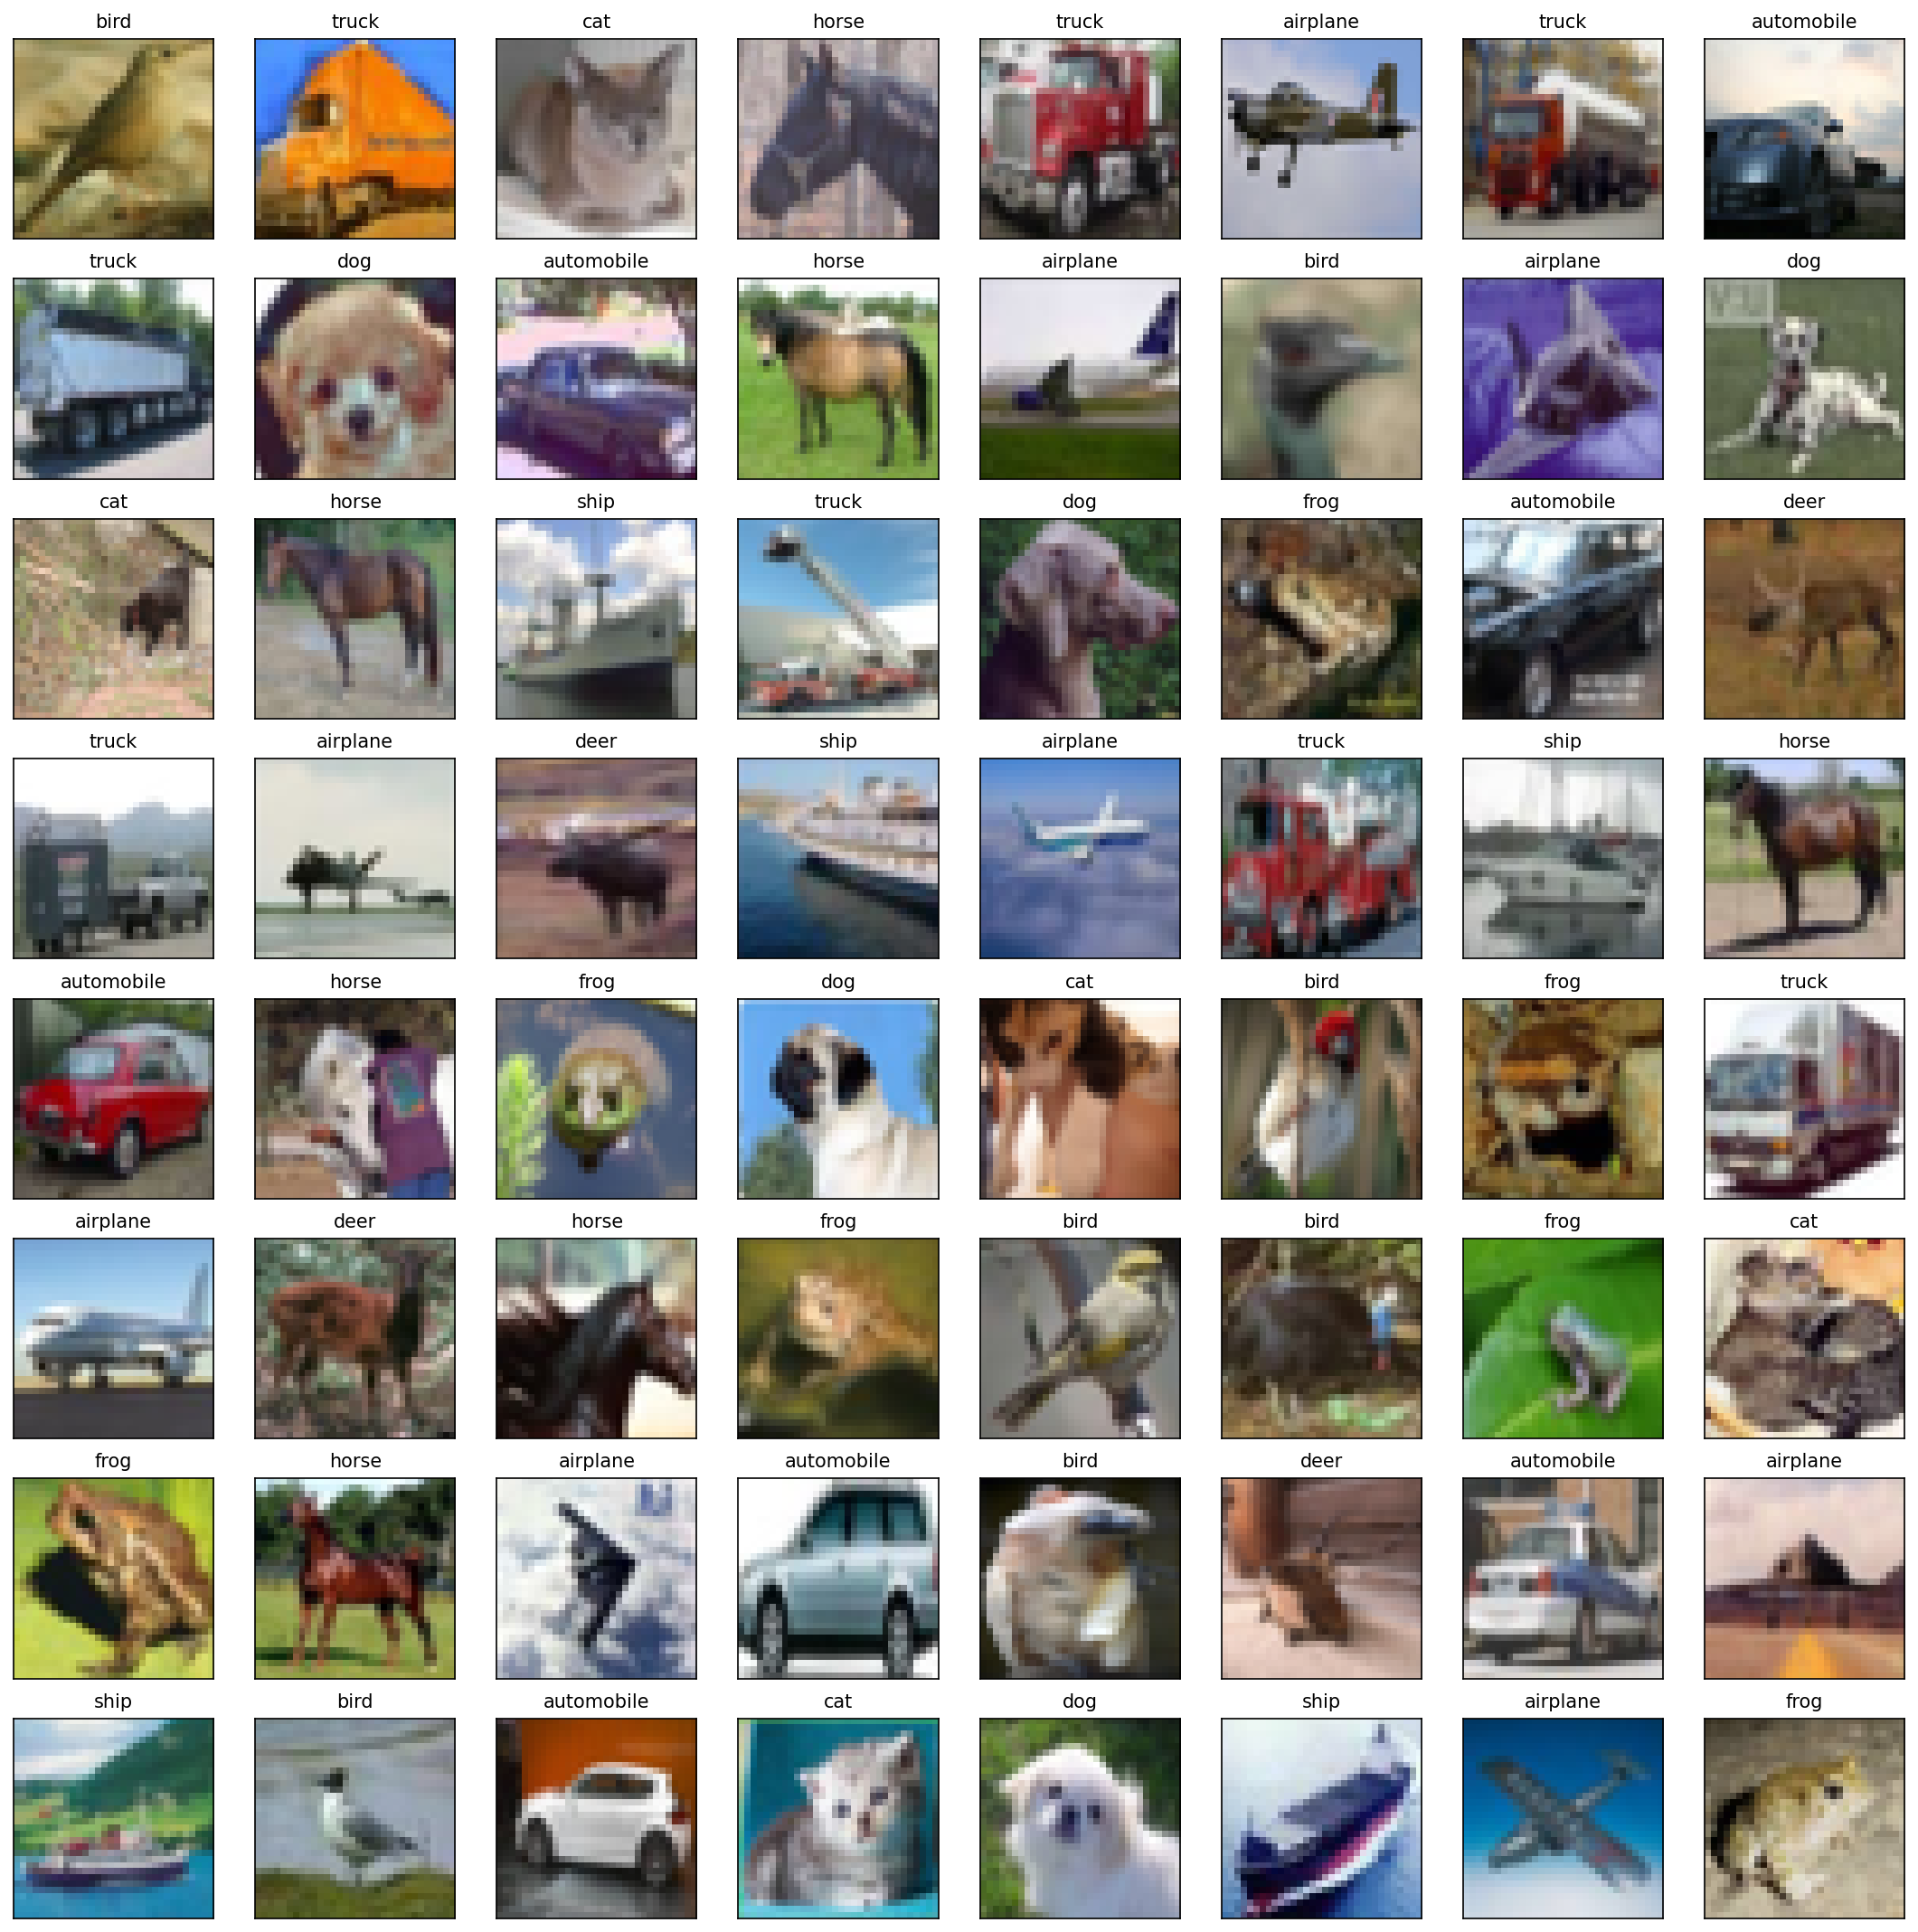

In [19]:
# overview of the dataset
class_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(18, 18), dpi=150)
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    plt.title(class_name[y_train[i][0]], fontsize=10)
plt.show()

In [23]:
# normalization of the data
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_valid = X_valid.astype('float32')

# getting the mean and standard deviation
mean = np.mean(X_train)
std = np.std(X_train)

# Normalize the data
X_train = (X_train-mean)/(std+1e-7)
X_test = (X_test-mean)/(std+1e-7)
X_valid = (X_valid-mean)/(std+1e-7)

In [25]:
# one -hot encoding inorder to transform the categorical columns into format suitable for multi-class classification
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
y_valid = to_categorical(y_valid, 10)

# Data Augmentation
Implement data augmentation to artificially expand the size of the training set by creating modified versions of images in the dataset. This helps improve the model's ability to generalize, thereby reducing overfitting. Data augmentation techniques such as rotations, shifts, flips, shearing, and intensity changes introduce small variations to the existing images, creating a broader set of training samples to learn from.

The choice of data augmentation techniques often depends on the specific characteristics of the dataset and the problem at hand. The CIFAR-10 dataset comprises small color images of objects from 10 different classes. Given the nature of these images, some augmentation techniques are more applicable than others:

    Rotation: A small degree of rotation can help the model become invariant to the orientation of the object. The rotation_range=15 means the image could be rotated randomly within -15 to 15 degrees. However, large rotations could be harmful since the CIFAR-10 images are relatively small and a big rotation might put the object outside of the image.

    Width and Height shift: Small shifts can help the model become invariant to the position of the object in the image. Here, width_shift_range=0.12 and height_shift_range=0.12 mean the image could be moved horizontally or vertically by up to 12% of its width or height respectively. Again, since the images are small, large shifts might put the object outside of the image.

    Horizontal Flip: A horizontal flip is a sensible choice for this dataset because for many images, the object of interest remains the same when flipped horizontally (for example, a flipped car is still a car).

    Zoom: Small zooming in by up to 10% (zoom_range=0.1) can also help the model generalize better. However, excessive zooming might lead to significant information loss.

    Brightness Range: Changing brightness can simulate various lighting conditions. With brightness_range=[0.9,1.1], the brightness of the image is randomly changed to a value between 90% and 110% of the original brightness.

    Shear Intensity: With shear_range=10, a shear intensity within the range of -10 to +10 degrees is applied. This transformation slants the shape of the image, helping the model to recognize objects in different perspectives.

    Channel Shift Intensity: With channel_shift_range=0.1, the intensities of the RGB channels are randomly shifted by up to 10% of their full scale. This can help the model handle different lighting conditions and color variations.

While some augmentation techniques like vertical flips and color jittering may not be appropriate for all classes in the CIFAR-10 dataset, the chosen techniques are expected to help improve the robustness and generalization capability of the model.


In [26]:
data_generator = ImageDataGenerator(
    # rotate images randomly by upto 15 degrees
    rotation_range=15,

    # shift images horozontally by upto 12% of their width
    width_shift_range=.12,

    # shift image vertically by upto 12% of their height
    height_shift_range=.12,

    # randomly flip images horizontally
    horizontal_flip=True,

    # zoom images in by upto 10%
    zoom_range=.1,

    # change brigtness by upto 10%
    brightness_range=[.9, 1.1],

    # # Shear intensity (shear angle in counter-clockwise direction in degrees)
    shear_range=10,

    #channel shift intensity
    channel_shift_range=.1
    
)

- <h4>
    When running the above code, we are setting up a pipeline for preprocessing the images during model training. The generator applies a series of random transformations (specified by the parameters) to the images each time they are loaded into the model for training. Each time an epoch is run during model training, these random transformations will create different variations of the original images. These changes are made on-the-fly and don't modify our original dataset.
</h4>

# CNN
The model architecture I am going to define is inspired from the VGG16 network. It contains multiple convolutional layers followed by max-pooling and dropout layers, and finally a fully connected layer for classification. While not adopting advanced modules like residuals or inceptions, this design is simpler, ensuring fewer parameters and a more straightforward architecture, making it more computationally efficient.

Here is a brief explanation of the architecture:

    The network begins with a pair of Conv2D layers, each with 32 filters of size 3x3. This is followed by a Batch Normalization layer which accelerates training and provides some level of regularization, helping to prevent overfitting.

    The pairs of Conv2D layers are followed by a MaxPooling2D layer, which reduces the spatial dimensions (height and width), effectively providing a form of translation invariance and reducing computational complexity. This is followed by a Dropout layer that randomly sets a fraction (0.2 for the first dropout layer) of the input units to 0 at each update during training, helping to prevent overfitting.

    This pattern of two Conv2D layers, followed by a Batch Normalization layer, a MaxPooling2D layer, and a Dropout layer, repeats three more times. The number of filters in the Conv2D layers doubles with each repetition, starting from 32 and going up to 64, 128, and then 256. This increasing pattern helps the network to learn more complex features at each level. The dropout rate also increases at each step, from 0.2 to 0.5.

    After the convolutional and pooling layers, a Flatten layer is used to convert the 2D outputs of the preceding layer into a 1D vector.

    Finally, a Dense (or fully connected) layer is used for classification. It has 10 units, each representing one of the 10 classes of the CIFAR-10 dataset, and a softmax activation function is used to convert the outputs to probability scores for each class.

This architecture leverages the strengths of deep CNNs to learn hierarchical features from the CIFAR-10 images. Regularization techniques such as L2 regularization, Dropout, and Batch Normalization are also used to combat overfitting. While being inspired by VGG16, the model remains simpler and does not incorporate the more advanced features of recent architectures, focusing instead on efficiency and simplicity.


In [30]:
# imitialize a sequential model
model = Sequential()

# set the weight decay value for l2 regularization
weight_decay = 0.0001

# Add the first convolutional layer with 32 filters of size 3x3
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay),
                input_shape=X_train.shape[1:]))
# add a batch normalization layer
model.add(BatchNormalization())

# add the second convolutional layer similar to first one
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# add the first maxpooling layer with pool size 2*2
model.add(MaxPooling2D(pool_size=(2,2)))

# add dropout layer with .2 dropout rate
model.add(Dropout(rate=.2))

# add the third and fourth convolutional layer with 64 filters
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# add the second max pooling layer and increase dropout rate to .3
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(rate=.3))

# add the fifth and sixth convolutional layer with 128 filters
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# add the 3rd maxpooling layer and increase droupout rate to .4
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(rate=.4))

# add the seventh and eighth convolutional layer with 256 filters
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the fourth max pooling layer and increase dropout rate to 0.5
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(rate=.5))

# flatten the tensor output from the previous layer
model.add(Flatten())

# Add a fully connected layer with softmax activation function for outputting class probabilities
model.add(Dense(10, activation='softmax'))

In [31]:
# display the summary of the model
model.summary()
# Our model consists of 1,186,346 parameters, of which 1,184,426 are trainable. 
# This is a relatively compact model, especially when compared to advanced architectures 
# which often have tens or even hundreds of millions of parameters.

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,186,346 (4.53 MB)

 Trainable params: 1,184,426 (4.52 MB)

 Non-trainable params: 1,920 (7.50 KB)

# Trainning the CNN Model
Now, I am going to train my neural network model. The training uses a batch size of 64 and will run for a maximum of 250 epochs or until the early stopping condition is met. During the training, the model's performance is evaluated on the validation data after each epoch. I've added a couple of callback functions to enhance the training process:

    The ReduceLROnPlateau callback is used to reduce the learning rate by half (factor=0.5) whenever the validation loss does not improve for 10 consecutive epochs. This helps to adjust the learning rate dynamically, allowing the model to get closer to the global minimum of the loss function when progress has plateaued. This strategy can improve the convergence of the training process.

    The EarlyStopping callback is employed to monitor the validation loss and halt the training process when there hasn't been any improvement for a certain number of epochs, ensuring that the model doesn't waste computational resources and time. Furthermore, this callback restores the best weights from the training process, ensuring we conclude with the optimal model configuration from the epochs.



In [ ]:
# set the batch size of the training 
batch_size = 64

# set the maximum number of epochs for the training 
epochs = 300

# Default optimizer
optimizer = Adam(learning_rate=.0005)

# Compile the model with the defined optimizer, loss function, and metrics
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Add ReduceLROnPlateau callback
# Here, the learning rate will be reduced by half (factor=0.5) if no improvement in validation loss is observed for 10 epochs
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=.5,
    patience=10, min_lr=.00001
)

# Add EarlyStopping callback
# Here, training will be stopped if no improvement in validation loss is observed for 40 epochs.
# The `restore_best_weights` parameter ensures that the model weights are reset to the values from the epoch
# with the best value of the monitored quantity (in this case, 'val_loss')